# Juliaで固有値問題を精度保証付き数値計算したい


## 固有値問題とは

固有値問題は与えられた行列の固有値および固有ベクトルを求めること。つまり、
$
\newcommand{\C}{\mathbb{C}}
\newcommand{\IC}{\mathbb{IC}}
\newcommand{\bX}{\bar{X}}
$

$$
Ax=\lambda x,\quad A\in \C^{n\times n}
$$

を満たす $\lambda\in \C$, $x\in \C^{n\times n}$ ($x\neq 0$) を求める問題を指す。

Juliaで固有値と固有ベクトルを求める際には、`LinearAlgebra`パッケージに含まれている関数`eigen`・`eigvals`・`eigvecs`で求めることができる。

|関数| 役割 |
|:-----------|:----------|
| eigen()    | 固有値・固有ベクトル両方  |
| eigvals()    | 固有値  |
| eigvecs()  | 固有ベクトル |

多分、Lapackの何かを呼び足してるはず。

In [1]:
using LinearAlgebra
val, vec  = eigen([1 2; 2 1])

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
2-element Array{Float64,1}:
 -1.0
  3.0
vectors:
2×2 Array{Float64,2}:
 -0.707107  0.707107
  0.707107  0.707107

In [2]:
val#固有値

2-element Array{Float64,1}:
 -1.0
  3.0

In [3]:
vec#固有ベクトル

2×2 Array{Float64,2}:
 -0.707107  0.707107
  0.707107  0.707107

In [4]:
eigvals([1 2; 2 1])#固有値

2-element Array{Float64,1}:
 -1.0
  3.0

In [5]:
eigvecs([1 2; 2 1])#固有ベクトル

2×2 Array{Float64,2}:
 -0.707107  0.707107
  0.707107  0.707107

## 密行列の固有値問題に対する精度保証

密行列とは、行列内のほとんどの要素が $0$ でない行列のことを指す。ここでは、行列$A\in\C^{n\times n}$ $(i=1,2,\cdots,n)$ の全ての固有値に対する精度保証アルゴリズムを考える。 

### 実装したいアルゴリズム
(1)
ある行列 $A$ の全ての近似固有ベクトル $\bX\in\C^{n\times n}$ $(i=1,2,\cdots,n)$ を求める。

(2)
$A\cdot\bX$ の包含 $C\in\IC^{n\times n}$ を求める。

(3)
区間連立1次方程式 $\bX G=C$ の解集合の包含 $G\supset \bX^{-1}\cdot C$ ($G\in\IC^{n\times n}$) を求める。

(4)
$G\in\IC^{n\times n}$ に対してゲルシュゴリンの定理を適用することを考える。

#### (1) 行列 $A$ の全ての近似固有ベクトル $\bX\in\C^{n\times n}$ $(i=1,2,\cdots,n)$ を求める。

行列 $A\in\C^{n\times n}$ $(i=1,2,\cdots,n)$ が対角化可能であるとするとき、$\lambda_i$ に対する固有ベクトル$x^{(i)}\in\C^{n}$ $(i=1,2,\cdots,n)$ を並べた行列

$$
X :=[x^{(1)},x^{(2)},\cdots,x^{(n)}]\in\C^{n\times n}
$$

によって、$A$ は

$$
X^{-1}AX = D = \rm{diag}(\lambda_1,\lambda_2,\cdots,\lambda_n)
$$

と対角化される。

In [1]:
using LinearAlgebra

n =100;
A = randn(n,n);

λ, X = eigen(A);

In [7]:
λ #固有値

100-element Array{Complex{Float64},1}:
 -9.354993607755423 - 3.10521804510489im
 -9.354993607755423 + 3.10521804510489im
 -8.829914109169227 + 0.0im
 -8.596852246470185 - 1.420381695818213im
 -8.596852246470185 + 1.420381695818213im
 -7.736385006247817 - 4.386708899636766im
 -7.736385006247817 + 4.386708899636766im
 -7.288022105164716 - 3.0070994784994345im
 -7.288022105164716 + 3.0070994784994345im
 -6.957330762988619 - 1.9038291222117576im
 -6.957330762988619 + 1.9038291222117576im
 -6.688403708534512 - 4.062016699665395im
 -6.688403708534512 + 4.062016699665395im
                    ⋮
  6.424818025552053 - 0.7526839287969654im
  6.424818025552053 + 0.7526839287969654im
  6.684710107899111 - 2.2067326219374404im
  6.684710107899111 + 2.2067326219374404im
   7.06321456373899 - 5.976599344387202im
   7.06321456373899 + 5.976599344387202im
    8.0111505899481 + 0.0im
  8.642183684411435 - 2.8700248930404797im
  8.642183684411435 + 2.8700248930404797im
  9.587731644661712 - 2.76728105018

In [8]:
X #固有ベクトル

100×100 Array{Complex{Float64},2}:
  -0.0324332-0.0676809im    -0.0324332+0.0676809im   …    -0.123008+0.0im
  -0.0256079+0.073751im     -0.0256079-0.073751im          0.020085+0.0im
   0.0166231+0.160937im      0.0166231-0.160937im        -0.0877203+0.0im
   -0.221685-0.0im           -0.221685+0.0im             -0.0825351+0.0im
  0.00644233+0.0717538im    0.00644233-0.0717538im         0.300167+0.0im
  -0.0549602-0.006093im     -0.0549602+0.006093im    …     0.119811+0.0im
   -0.137734+0.0202734im     -0.137734-0.0202734im        0.0253535+0.0im
    0.160319-0.0596742im      0.160319+0.0596742im         0.064853+0.0im
   0.0486162-0.040065im      0.0486162+0.040065im         -0.116457+0.0im
 -0.00727075+0.00947815im  -0.00727075-0.00947815im      -0.0671906+0.0im
   -0.126487-0.10555im       -0.126487+0.10555im     …   -0.0373159+0.0im
  -0.0181367-0.00657198im   -0.0181367+0.00657198im       -0.126041+0.0im
  0.00204521+0.0281492im    0.00204521-0.0281492im        -0.085803+0.0im
   

しかし、実際のところ上記の数値計算で得られる固有ベクトル $X$ は近似の値 $\bX\in \C^{n\times n}$ (以下、近似固有ベクトルという) である。しかし、近似固有ベクトルを並べた行列を使って、対角化したものについては、対角優位性が期待できる。この行列を $G$ とすると、

$$
G := \bX^{-1}A\bX
$$

となり、行列 $G$ の対角成分は行列 $A$ の固有値の近似となる。

また、対角優位性とは、ある行列$A=(a_{ij})$について、

$$
\left|a_{i i}\right|>\sum_{{j} \colon j \neq i}\left|a_{i j}\right| \quad(i=1,2, \ldots, n)
$$

であること。つまり、行列のどの対角成分の絶対値も、それと同じ列にある非対角成分の和よりも大きい時。

In [9]:
G = inv(X)*A*X; #G
norm(diag(G) - λ,Inf) # Gの対角成分は固有値λにほぼ一致する

5.311895280018592e-14

#### (2) $A\cdot\bX$ の包含 $C\in\IC^{n\times n}$ を求める。

``方法1``各演算を区間演算に変更した方式(参考：[interval_dot-mul.ipynb](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/interval_dot-mul.html "タイトル"))

In [10]:
using IntervalArithmetic, BenchmarkTools

iA = map(Interval, A);
iX = map(Interval, X);

@btime C1 = $iA * $iX;

  82.239 ms (8 allocations: 312.91 KiB)


In [11]:
@show max(maximum(radius.(real(C1[:]))),maximum(radius.(imag(C1[:]))))

LoadError: UndefVarError: C1 not defined

``方法2``BLASを使う。int_num_linalg.jlの呼び出し。この方が早い。

In [2]:
using BenchmarkTools
include("IntervalLinearAlgebra.jl"); # int_mulを使用する
# @time C1 = mm_comp_interval_alt(iA,iX);
@time C = int_mul(A,X); # A, X: complex matrices (not interval)
@time C = int_mul(A,X); # A, X: complex matrices (not interval)
@time C = int_mul(A,X); # A, X: complex matrices (not interval)


  1.726199 seconds (6.24 M allocations: 291.731 MiB, 12.38% gc time)
  0.150193 seconds (105.65 k allocations: 4.592 MiB)
  0.155720 seconds (105.65 k allocations: 4.592 MiB)


In [13]:
max(maximum(radius.(real(C[:]))),maximum(radius.(imag(C[:]))))

9.059419880941277e-14

In [14]:
real(C)

100×100 Array{Interval{Float64},2}:
  [0.093248, 0.0932481]       …  [-1.26511, -1.2651]
  [0.468574, 0.468575]            [0.206569, 0.20657]
  [0.344236, 0.344237]           [-0.902183, -0.902182]
  [2.07386, 2.07387]             [-0.848854, -0.848853]
  [0.162543, 0.162544]            [3.08715, 3.08716]
  [0.495231, 0.495232]        …   [1.23223, 1.23224]
  [1.35145, 1.35146]              [0.260754, 0.260755]
 [-1.68509, -1.68508]             [0.666997, 0.666998]
 [-0.579215, -0.579214]          [-1.19774, -1.19773]
  [0.0974495, 0.0974496]         [-0.69104, -0.691039]
  [0.855526, 0.855527]        …  [-0.383786, -0.383785]
  [0.149261, 0.149262]           [-1.2963, -1.29629]
  [0.0682766, 0.0682767]         [-0.882464, -0.882463]
   ⋮                          ⋱  
  [1.03076, 1.03077]              [1.06538, 1.06539]
 [-0.452326, -0.452325]          [-0.98697, -0.986969]
 [-0.221006, -0.221005]       …   [0.456314, 0.456315]
 [-1.89666, -1.89665]            [-1.30269, -1.30268]
 [-1

In [15]:
imag(C)

100×100 Array{Interval{Float64},2}:
  [0.733866, 0.733867]     …  [-2.22508e-308, 2.22508e-308]
 [-0.610422, -0.610421]       [-2.22508e-308, 2.22508e-308]
 [-1.55719, -1.55718]         [-2.22508e-308, 2.22508e-308]
  [0.68838, 0.688381]         [-2.22508e-308, 2.22508e-308]
 [-0.691261, -0.69126]        [-2.22508e-308, 2.22508e-308]
  [0.227663, 0.227664]     …  [-2.22508e-308, 2.22508e-308]
  [0.238036, 0.238037]        [-2.22508e-308, 2.22508e-308]
  [0.060425, 0.0604251]       [-2.22508e-308, 2.22508e-308]
  [0.223843, 0.223844]        [-2.22508e-308, 2.22508e-308]
 [-0.0660908, -0.0660907]     [-2.22508e-308, 2.22508e-308]
  [1.38019, 1.3802]        …  [-2.22508e-308, 2.22508e-308]
  [0.117799, 0.1178]          [-2.22508e-308, 2.22508e-308]
 [-0.269687, -0.269686]       [-2.22508e-308, 2.22508e-308]
   ⋮                       ⋱  
 [-0.3235, -0.323499]         [-2.22508e-308, 2.22508e-308]
 [-0.0929236, -0.0929235]     [-2.22508e-308, 2.22508e-308]
  [0.82915, 0.829151]      …  [-2

#### (3 )区間連立1次方程式 $\hat XG=C$ の解集合の包含 $G\supset\hat X^{-1}\cdot C$ を求める。

In [3]:
function verifylss_ib(A,ib) # verify the solution element-wisely
    b = mid.(real(ib)) + mid.(imag(ib))*im;
    x̄ = A\b;
    n = length(x̄);
    R = inv(A);
    #########
    #C_mid, C_rad = mm_ufp(R,A);
    G = Matrix{Float64}(I, n, n) - int_mul(R,A);
    α = opnorm(G,Inf)# Interval arithmetic
    #########
    if α < 1
        x̄ = map(Interval,x̄);
        r = A*x̄ - ib; # Interval arithmetic
        Rr = R*r;
        err = abs.(Rr) + supremum(norm(Rr,Inf))/(1-α)*(abs.(G)*ones(n)); # Interval arithmetic
    else
        println("Oh my way, verification is failed...")
        err = nan;
    end
    return x = (real(x̄) .± supremum.(err)) + im*(imag(x̄) .± supremum.(err))
end

verifylss_ib (generic function with 1 method)

In [4]:
G = similar(C);
for i = 1:n
    G[:,i] = verifylss_ib(X,C[:,i]);
end
real(G)

┌ Warning: `supremum` is deprecated, use `sup` instead.
│   caller = verifylss_ib(::Array{Complex{Float64},2}, ::Array{Complex{Interval{Float64}},1}) at In[3]:15
└ @ Main ./In[3]:15
┌ Warning: `supremum` is deprecated, use `sup` instead.
│   caller = _broadcast_getindex_evalf at broadcast.jl:630 [inlined]
└ @ Core ./broadcast.jl:630


100×100 Array{Interval{Float64},2}:
 [-10.8269, -10.8268]          …  [-1.31215e-12, 1.35827e-12]
  [-1.0999e-12, 1.10066e-12]      [-1.80161e-12, 1.74029e-12]
  [-1.0999e-12, 1.10066e-12]      [-1.76533e-12, 1.78192e-12]
  [-1.56657e-12, 1.56793e-12]     [-1.83778e-12, 1.8581e-12] 
  [-3.04066e-12, 3.03839e-12]     [-3.59607e-12, 3.56427e-12]
  [-2.18775e-12, 2.18753e-12]  …  [-3.63399e-12, 3.62538e-12]
  [-2.18775e-12, 2.18753e-12]     [-3.62476e-12, 3.64271e-12]
  [-3.25612e-12, 3.25702e-12]     [-5.16231e-12, 5.17514e-12]
  [-3.25612e-12, 3.25702e-12]     [-5.18848e-12, 5.15823e-12]
  [-1.35397e-12, 1.35342e-12]     [-2.20064e-12, 2.21401e-12]
  [-1.35397e-12, 1.35342e-12]  …  [-2.21517e-12, 2.18259e-12]
  [-3.23737e-12, 3.22412e-12]     [-3.78045e-12, 3.81705e-12]
  [-1.94959e-12, 1.95817e-12]     [-3.16757e-12, 3.17731e-12]
    ⋮                          ⋱                             
  [-7.75792e-13, 7.68648e-13]     [-1.27434e-12, 1.28294e-12]
  [-3.19351e-12, 3.19466e-12]     

In [18]:
[real(diag(G)), λ]

2-element Array{Array{T,1} where T,1}:
 Interval{Float64}[[-9.355, -9.35499], [-9.355, -9.35499], [-8.82992, -8.82991], [-8.59686, -8.59685], [-8.59686, -8.59685], [-7.73639, -7.73638], [-7.73639, -7.73638], [-7.28803, -7.28802], [-7.28803, -7.28802], [-6.95734, -6.95733]  …  [6.68471, 6.68472], [6.68471, 6.68472], [7.06321, 7.06322], [7.06321, 7.06322], [8.01115, 8.01116], [8.64218, 8.64219], [8.64218, 8.64219], [9.58773, 9.58774], [9.58773, 9.58774], [10.2847, 10.2848]]
 Complex{Float64}[-9.354993607755423 - 3.10521804510489im, -9.354993607755423 + 3.10521804510489im, -8.829914109169227 + 0.0im, -8.596852246470185 - 1.420381695818213im, -8.596852246470185 + 1.420381695818213im, -7.736385006247817 - 4.386708899636766im, -7.736385006247817 + 4.386708899636766im, -7.288022105164716 - 3.0070994784994345im, -7.288022105164716 + 3.0070994784994345im, -6.957330762988619 - 1.9038291222117576im  …  6.684710107899111 - 2.2067326219374404im, 6.684710107899111 + 2.2067326219374404im, 7.063214563

#### 4) $G\in\IC^{n\times n}$ に対してゲルシュゴリンの定理を適用することを考える。


## ゲルシュゴリンの包含定理
行列 $A=(A_{ij})\in \C^{n\times n}$ について、$A$ の全ての固有値 $\lambda_i$ は、$\bigcup_{1\le i \le n}  U_i$ の内部に存在する。

$$
A\subseteq\bigcup_{1\le i \le n}  U_i 
$$

ただし、

$$
U_i = \left\{z\in\mathbb{C}:|z-a_{ii}|\le \sum_{j\neq i}|a_{ij}|\right\}
$$

である。円盤領域 $U_i$ をゲルシュゴリン円板といい、$A$ が強い優対角性を持つとき、$A$ の対角成分が $A$ の固有値の良い近似となる。今回の場合、$G=(g_{ij})_{1\le i,j\le n}\in\IC^{n\times n}$ の対角成分 $(g_{ii})_{1\le i\le n}$ を $(c_{i})_{1\le i\le n}\in \IC^{n}$ とし、各成分の半径を $\mathrm{rad}(c_i)$ とすると、

$$
\begin{array}{ll}
\mbox{ゲルシュゴリン円の中心:}&\mathrm{mid}(c_i)\\
\mbox{ゲルシュゴリン円の半径:}&r_i=\sum_{j\neq i}\rm{mag}(g_{ij})+\rm{rad}(c_{i})\\
\end{array}
$$

となる。

In [5]:
import IntervalArithmetic: mag, radius, mid
function mag(v::Complex{Interval{T}}) where T# mag function for complex interval vectors
    abs_v = abs(v);
    return max(abs_v.lo,abs_v.hi)
end

function radius(v::Complex{Interval{T}}) where T# mag function for complex interval vectors
    return sqrt(interval(radius(real(v)))^2 + interval(radius(imag(v)))^2)
end

function mid(v::Complex{Interval{T}}) where T# mag function for complex interval vectors
    return mid(real(v)) + mid(imag(v))*im
end

mid (generic function with 7 methods)

In [6]:
r = zeros(n);
c = diag(G);
# G_org = G;
# for i ∈ 1:n
#     G[i,i] = 0;
# end
for i = 1:n
    for j = 1:n
        if i != j
            r[i] += mag(G[i,j]);
        end
    end
    r[i] += mag(radius.(c[i]));
end
λc = mid.(c);

In [7]:
iλ = (real(λc) .± r) + im*(imag(λc) .± r);
[real(iλ) imag(iλ)]

100×2 Array{Interval{Float64},2}:
 [-10.8269, -10.8268]   [-1.82262e-10, 1.82262e-10]
  [-9.42296, -9.42295]  [-3.20878, -3.20877]       
  [-9.42296, -9.42295]   [3.20877, 3.20878]        
  [-8.89599, -8.89598]  [-2.50883e-10, 2.50883e-10]
  [-8.10239, -8.10238]  [-4.84469e-10, 4.84469e-10]
  [-7.84368, -7.84367]  [-2.23218, -2.23217]       
  [-7.84368, -7.84367]   [2.23217, 2.23218]        
  [-7.71808, -7.71807]  [-1.36402, -1.36401]       
  [-7.71808, -7.71807]   [1.36401, 1.36402]        
  [-7.4548, -7.45479]   [-4.63452, -4.63451]       
  [-7.4548, -7.45479]    [4.63451, 4.63452]        
  [-6.74216, -6.74215]  [-5.10127e-10, 5.10127e-10]
  [-5.68876, -5.68875]  [-6.01145, -6.01144]       
    ⋮                                              
   [6.89653, 6.89654]    [7.70166, 7.70167]        
   [7.56557, 7.56558]   [-4.48812, -4.48811]       
   [7.56557, 7.56558]    [4.48811, 4.48812]        
   [7.7546, 7.75461]    [-3.80182, -3.80181]       
   [7.7546, 7.75461]     [3.80

In [22]:
sum(λ .∈ iλ)

100

In [23]:
r = sup.(radius.(iλ));

In [24]:
r

100-element Array{Float64,1}:
 2.5775689971618714e-10
 3.3222214370332833e-10
 3.3219796428020675e-10
 3.548020512398507e-10 
 6.851440445858652e-10 
 6.685996941066956e-10 
 6.685324941494641e-10 
 9.538223761326248e-10 
 9.534548174883701e-10 
 4.099253914464924e-10 
 4.0973949249938446e-10
 7.214274516095858e-10 
 5.884392516655053e-10 
 ⋮                     
 2.3492414207592414e-10
 9.642226685789462e-10 
 9.642226685789462e-10 
 1.419449937735395e-9  
 1.4195278143213457e-9 
 4.197765577932181e-9  
 4.197684001815958e-9  
 8.222994990908256e-10 
 8.22450856004562e-10  
 1.4861623885082022e-9 
 3.3098114262398693e-10
 3.309246192954744e-10 

※11/25↓
https://hsugawa8651.github.io/memojuliav064/ch13.html#%E3%82%AC%E3%82%A6%E3%82%B9%E5%B9%B3%E9%9D%A2-1
を参考に図示しようとしたが、Plotsが上手く作動せずにエラー。

In [13]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


WARNING: using Plots.center in module Main conflicts with an existing identifier.

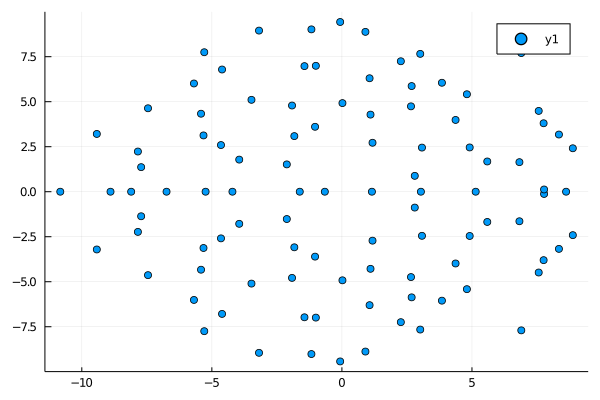

In [67]:
i=1
zs = [ λ[i] +  r[i]*exp(im*t) for t in 0:pi/100:2pi ]
# plot( real(zs), imag(zs),linewidth=1)
# i = 2
# zs = [ λ[i] +  r[i]*exp(im*t) for t in 0:pi/100:2pi ]
# plot!( real(zs), imag(zs),linewidth=50)
plot(real(λ), imag(λ), seriestype = :scatter)

# end
# xlabel("real part")
# ylabel("imag part")
# axhline(0, lw=0.5, color="k")
# axvline(0, lw=0.5, color="k")
# plt[:axes]()[:set_aspect]("equal")
# plot(index, max_rad, yscale=:log10,
#     xlabel       ="n",                #X軸のラベル
#     ylabel       ="maximum radius",   #Y軸のラベル
#     xlims        =(0,41),             #X軸の範囲
#     title="Error bounds of IG",       #タイトル
#     linewidth    =2,                  #線幅
#     seriestype = :scatter,            #点プロットに　
#     size         =(400,300),          #プロットのサイズ
#     label = "without pre-conditioned",#凡例のラベル
#     legend = false,                   #凡例は今回は消す
# )

In [54]:
size([r*exp(im*t) for t in 0:pi/100:2pi ])

(200,)

In [56]:
zs = [ λ[1:3] +  r[1:3]*exp(im*t) for t in 0:pi/100:2pi ]
size(zs)

(200,)

In [42]:
# 開始値:ステップ:終了値
x = -5.0:0.1:5.0
# 関数
f(x) = 1 ./ (1 .+ exp.(-x))

y = f(x)

using Plots
plot(x, y)
# 画像保存
savefig("Sigmoid.png")

In [43]:

plot!(index, max_rad, yscale=:log10,
    xlabel       ="Real",                #X軸のラベル
    ylabel       ="Imaginary",   #Y軸のラベル
    xlims        =(0,41),             #X軸の範囲
    title="gershgorin",       #タイトル
    linewidth    =2,                  #線幅
    seriestype = :scatter,            #点プロットに　
    size         =(400,300),          #プロットのサイズ
)

LoadError: UndefVarError: index not defined

In [44]:
zs = [ complex(0,0), complex(1,0), complex(1,1), complex(0,1), complex(0,0)]

plot( real.(zs), imag.(zs), ".-")
xlabel("real part")
ylabel("imag part")
xlim(-2,2)
ylim(-2,2)
axhline(0, lw=0.5, color="k")
axvline(0, lw=0.5, color="k")
plt[:axes]()[:set_aspect]("equal")

LoadError: Cannot convert String to series data for plotting

In [45]:
using PyPlot
zs = [ complex(0,0), complex(1,0), complex(1,1), complex(0,1), complex(0,0)]

plot( real.(zs), imag.(zs), ".-")
xlabel("real part")
ylabel("imag part")
xlim(-2,2)
ylim(-2,2)
axhline(0, lw=0.5, color="k")
axvline(0, lw=0.5, color="k")
plt[:axes]()[:set_aspect]("equal")

LoadError: Cannot convert String to series data for plotting

In [50]:
using PyPlot
b=1
cs=linspace(-2,2)
ds=complex(b.*b-4cs)
x1s=(b+sqrt.(ds))/2;
x2v=cs./x1s;
plot(cs, real.(x1s), "b-", label="x1, real part")
plot(cs, imag.(x1s), "b:", label="x1, imag part")
plot(cs, real.(x2v), "g-", label="x2, real part")
plot(cs, imag.(x2v), "g:", label="x2, imag part")
legend()
xlabel("c")
xlim(-2.5,2.5)
ylim(-2.5,2.5)
axhline(0, lw=0.5, color="k")
axvline(0, lw=0.5, color="k")
plt[:axes]()[:set_aspect]("equal")

LoadError: UndefVarError: linspace not defined

対角優位
http://www.math.ritsumei.ac.jp/~yasutomi/jugyo/Numerical_Analysis/note5.pdf

計算途中がでる
http://www.cas.cmc.osaka-u.ac.jp/~paoon/misc/julia/post/cg/


http://infsup.jp/saito/materials/na19exer.pdf